In [1]:
# code taken from source https://www.kaggle.com/code/derinrobert/newsclassification-using-lstm-val-acc-72

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-8f35d7126177>:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_json('drive/MyDrive/input/News_Category_Dataset_v3.json',lines=True)
beforeMay2018 = df[pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')<="2019-01-31"]

required_columns = ["BLACK VOICES",
                    "COMEDY",
                    "CRIME",
                    "DIVORCE",
                    "GREEN",
                    "HOME & LIVING",
                    "IMPACT",
                    "MEDIA",
                    "PARENTS",
                    "RELIGION",
                    "SPORTS",
                    "STYLE",
                    "THE WORLDPOST",
                    "WEDDINGS",
                    "WEIRD NEWS",
                    "WOMEN",
                    "WORLD NEWS",
                    "WORLDPOST"]
df = df[df["date"] < "2018-05-26"]
df = df[df["category"].isin(required_columns)]

df.drop(['authors', 'link', 'date'], axis = 1, inplace = True)

df.head()

<ipython-input-3-fdc3fdde0896>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['authors', 'link', 'date'], axis = 1, inplace = True)


,headline,category,short_description
8697,North Korea Still Open To Talks After Trump Cancels Summit,WORLD NEWS,Trump’s announcement came after repeated threats by North Korea to pull out of the summit over what it saw as confrontational remarks by U.S. officials.
8698,"2 Men Detonate Bomb Inside Indian Restaurant Near Toronto, Authorities Say",WORLD NEWS,"Fifteen people were taken to the hospital, three of them with critical injuries."
8699,Thousands Travel Home To Ireland To Vote On Abortion Access,WORLD NEWS,Just try to read these #HomeToVote tweets without crying.
8700,"Irish Voters Set To Liberalize Abortion Laws In Landslide, Exit Poll Signals",WORLD NEWS,Vote counting will begin Saturday.
8701,Warriors Coach Steve Kerr Calls NFL Ban On Protests 'Fake Patriotism',BLACK VOICES,"Forbidding players to take a knee during the national anthem is “idiotic,” the coach said."


In [4]:
print("We have a total of {} categories now".format(df['category'].nunique()))
df['category'].value_counts()

We have a total of 18 categories now


COMEDY           5175
SPORTS           4884
BLACK VOICES     4528
HOME & LIVING    4195
PARENTS          3955
THE WORLDPOST    3664
WEDDINGS         3651
WOMEN            3490
IMPACT           3458
DIVORCE          3426
CRIME            3404
MEDIA            2815
WEIRD NEWS       2668
GREEN            2622
WORLDPOST        2579
RELIGION         2556
STYLE            2254
WORLD NEWS       2176
Name: category, dtype: int64

In [5]:
#from https://www.kaggle.com/code/dima806/news-category-classification-distilbert

item0 = df.shape[0]  # Store the initial number of items in the DataFrame
df = df.drop_duplicates()  # Remove duplicate rows from the DataFrame
item1 = df.shape[0]  # Store the number of items in the DataFrame after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Print the number of duplicates removed

df = df.rename(columns={'category': 'label'})  # Rename the 'category' column to 'label'

df['title'] = df['headline'] + ' ' + df['short_description']  # Create a new 'title' column by combining 'headline' and 'short_description'

df = df[['label', 'title']]  # Select only the 'label' and 'title' columns
df = df[~df['title'].isnull()]  # Remove rows where 'title' is null
df = df[~df['label'].isnull()]  # Remove rows where 'label' is null

print(df.shape)  # Print the shape of the DataFrame after data preprocessing
df.sample(5).T  # Display a random sample of 5 rows from the DataFrame

There are 218 duplicates found in the dataset
(61282, 2)


,112873,82840,134585,148530,147926
label,RELIGION,MEDIA,HOME & LIVING,BLACK VOICES,HOME & LIVING
title,"What This Gay Atheist Learned From Being an Evangelical Christian After a few years outside the isolation of an Evangelical community, these are values I find most lacking in the mainstream and would pass on to others who are still building their own identities.","NBC Executive Calls Undocumented Immigrants ""Illegals"" In Meeting With Latino Lawmakers Deborah Turness used the term, which many consider a racial slur, during a discussion about diversity at her network.","The ""Three Turkeys"": Making Sense of 30 March Local Elections The message these elections have hammered home, and here the ""context"" does matter, is the apparent lack of willingness on the part of these groups to continue to live together.","This Day In History: Howard University School Of Medicine Opens A high school diploma was not a requirement for admission until 1903. By 1871, the requirements for admission were: The applicant","You Can Now Turn Your Instagram Pictures Into Custom Wrapping Paper Dorrian Porter of creative studio Northern Imagination has created PicPaperie, an upcoming service that will allow you to"


In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import gensim
from gensim.models import Word2Vec

In [7]:
!pip install neattext

In [8]:
import neattext.functions as nfx
nltk.download('wordnet')
nltk.download('punkt')

lemmatizer = WordNetLemmatizer()
tknzr = nltk.tokenize

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tknzr.word_tokenize(text)]

corpus = df['title'].astype(str)
corpus = corpus.apply(nfx.remove_stopwords)
corpus = corpus.apply(nfx.remove_special_characters)
corpus = corpus.apply(nfx.remove_multiple_spaces)
corpus = corpus.str.lower()
corpus = corpus.apply(lemmatize_text)

df['label'] = df['label'].apply(lambda x: x.replace(' ', ''))


df['title'] = corpus

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Tidying

In [9]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

In [10]:
df['label'].head(10)

0    WOMEN       
1    WORLDNEWS   
2    DIVORCE     
3    SPORTS      
4    WOMEN       
5    IMPACT      
6    HOME&LIVING 
7    THEWORLDPOST
8    CRIME       
9    DIVORCE     
Name: label, dtype: object

# Tokenizing and Padding

In [11]:
X,Y = df['title'],df['label']

#80% to train , 10% for validation , 10% for testing
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42, stratify = y_val)

In [12]:
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [13]:
from gensim.models.keyedvectors import KeyedVectors
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

word_vectors = KeyedVectors.load_word2vec_format('drive/MyDrive/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [14]:

from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
num_tokens = len(tokenizer.word_index.items()) + 2
vocabulary_size = min(len(word_index)+1, num_tokens)


EMBEDDING_DIM = 300

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)

y_train = to_categorical(np.asarray(y_train.factorize()[0]),18)

smote = SMOTE(sampling_strategy="minority",random_state=42)
X_train,y_train = smote.fit_resample(X_train, y_train)


X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)




(51417, 300)
(51417, 18)
(6128, 300)
(6128, 18)


In [15]:


embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=num_tokens:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)


embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)

# Model Training

In [16]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

tf.keras.backend.clear_session()

embed_size = 300

model = keras.models.Sequential([

      embedding_layer,
        keras.layers.Bidirectional(keras.layers.LSTM(256, dropout = 0.4)),
        keras.layers.Dense(18, activation="softmax")

        ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         14271600  
                                                                 
 bidirectional (Bidirection  (None, 512)               1140736   
 al)                                                             
                                                                 
 dense (Dense)               (None, 18)                9234      
                                                                 
Total params: 15421570 (58.83 MB)
Trainable params: 1149970 (4.39 MB)
Non-trainable params: 14271600 (54.44 MB)
_________________________________________________________________


In [17]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(train_set,train_label,
                     batch_size = 32,
                     steps_per_epoch=len(X_train) // 32,
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=20,
                     callbacks= early_stop)

Epoch 1/20
1606/1606 [==============================] - 75s 44ms/step - loss: 1.4986 - accuracy: 0.5323 - val_loss: 5.3287 - val_accuracy: 0.0730
Epoch 2/20
1606/1606 [==============================] - 67s 42ms/step - loss: 1.1671 - accuracy: 0.6325 - val_loss: 5.7408 - val_accuracy: 0.0805
Epoch 3/20
1606/1606 [==============================] - 65s 40ms/step - loss: 1.0418 - accuracy: 0.6646 - val_loss: 6.1384 - val_accuracy: 0.0789
Epoch 4/20
1606/1606 [==============================] - 65s 41ms/step - loss: 0.9493 - accuracy: 0.6943 - val_loss: 6.2821 - val_accuracy: 0.0830


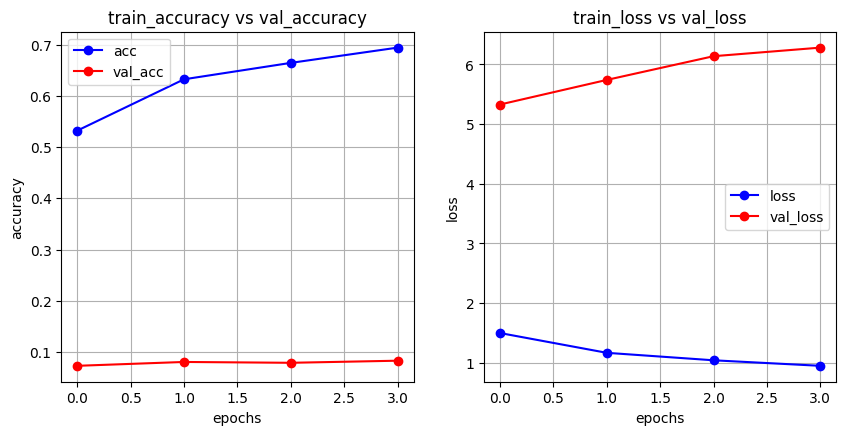

In [18]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


# Evaluating and Making Predictions

In [19]:
classes = df['label'].value_counts().index

def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X,maxlen= max_length,padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()
    return pred_value

192/192 [==============================] - 3s 14ms/step
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       453
           1       0.01      0.00      0.01       517
           2       0.02      0.03      0.02       340
           3       0.01      0.01      0.01       342
           4       0.03      0.01      0.02       261
           5       0.00      0.00      0.00       417
           6       0.01      0.01      0.01       346
           7       0.00      0.00      0.00       281
           8       0.01      0.01      0.01       390
           9       0.03      0.04      0.03       255
          10       0.00      0.00      0.00       489
          11       0.00      0.00      0.00       224
          12       0.00      0.00      0.00       367
          13       0.00      0.00      0.00       365
          14       0.02      0.04      0.03       267
          15       0.62      0.52      0.57       340
          16       0.01  

Text(0.5, 1.0, 'Confusion matrix of model')

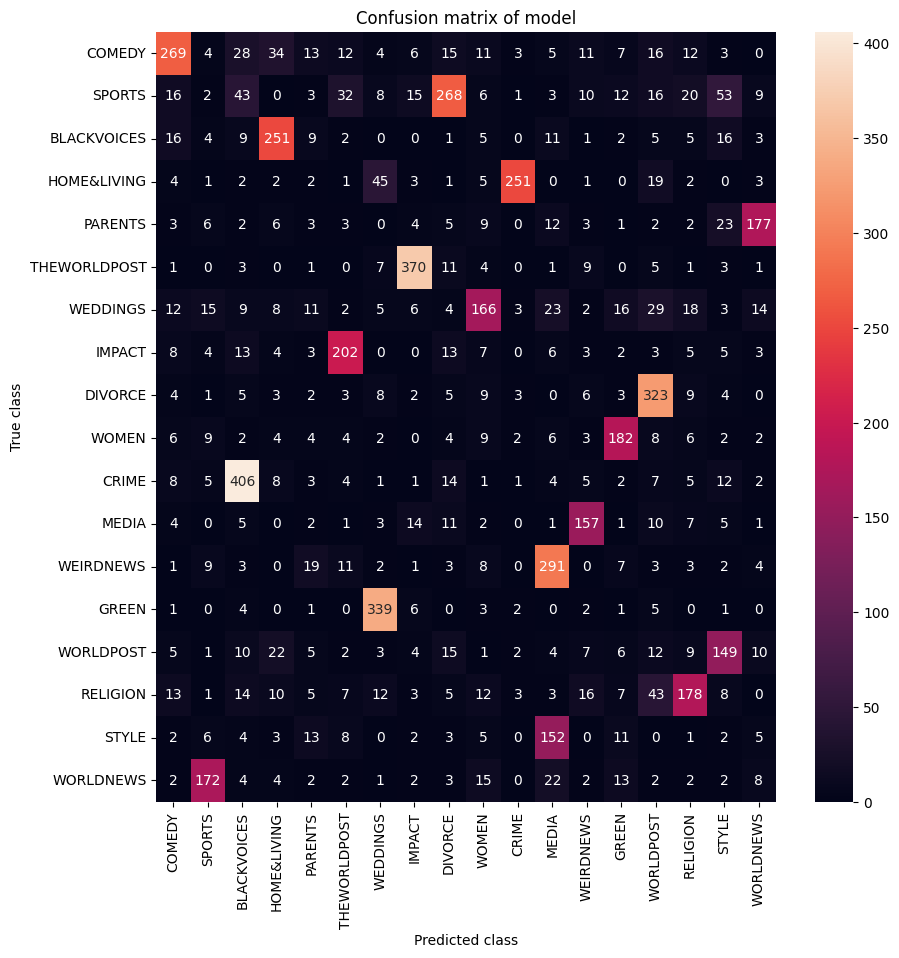

In [20]:
y_pred = prediction(X_test)
print(classification_report(np.asarray(y_test),np.asarray( y_pred)))
cf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')